# Feature engineering is the hard part
You apply your own intellegent to compliment the machine intellegence - by incorporating you knowelage what variable would discriminate best. That depends much on the problem. If there was a ready algorithm, it would be incorporated into the ML framework. In a sense, deep learning is automated feature engeneering.

## Procedure
 1. Imagine features
 2. Implement features
 3. Select features
 4. Evaluate performance
 5. Repeat

## Evaluating feature importance
 1. Compare scores with and without
 2. Look on .feature\_importances_

In [1]:
! pip install --upgrade sklearn

Requirement already up-to-date: sklearn in /root/miniconda/envs/rep_py2/lib/python2.7/site-packages
Requirement already up-to-date: scikit-learn in /root/miniconda/envs/rep_py2/lib/python2.7/site-packages (from sklearn)
You are using pip version 8.1.1, however version 8.1.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
import root_numpy
import pandas as pd
import numpy
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
data = pd.DataFrame(root_numpy.root2array("/notebooks/public_train_10000.root")).drop("event_id", axis=1)
target = data.target
features = data.drop("target", axis=1).astype(numpy.float64)

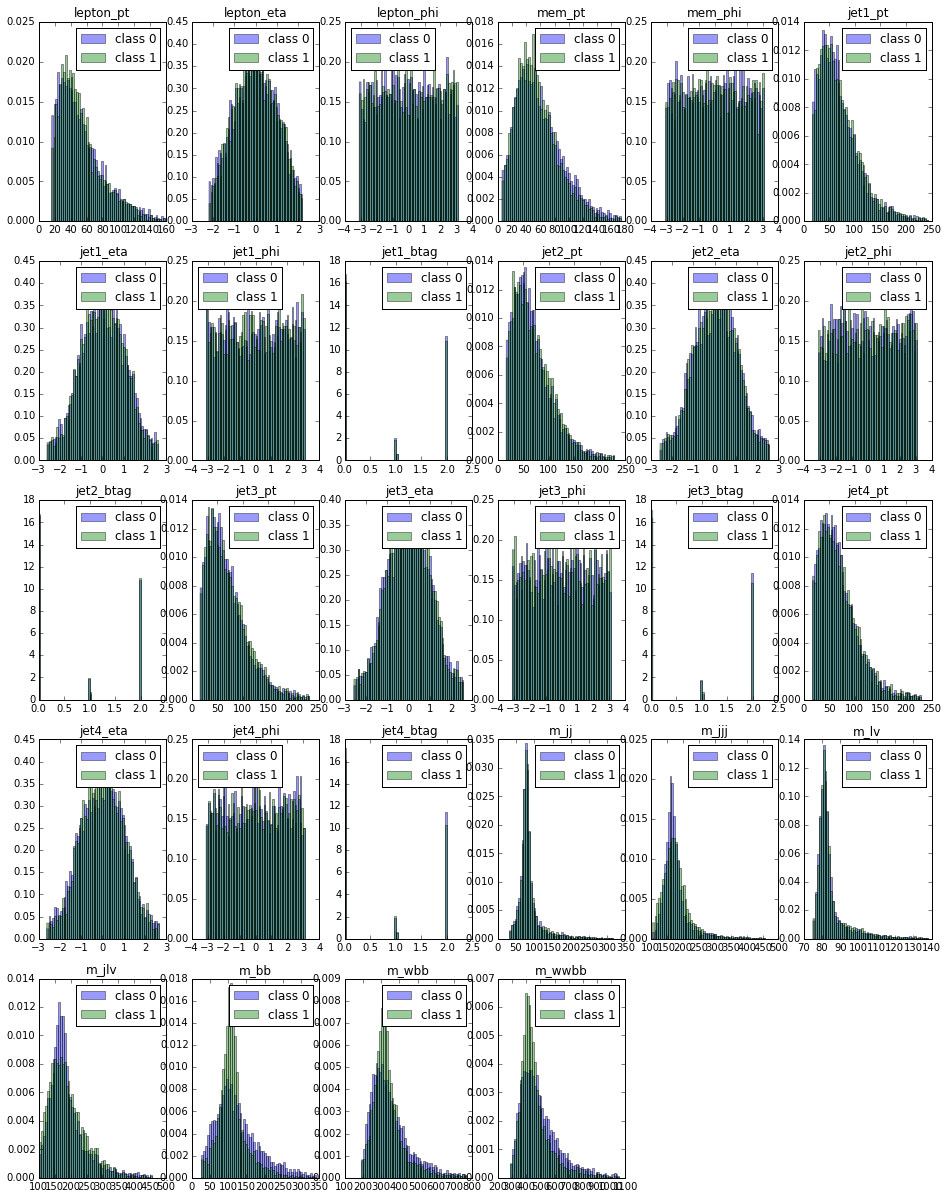

In [4]:
hist_params = {'normed': True, 'bins': 60, 'alpha': 0.4}
# create the figure
fig = plt.figure(figsize=(16, 25))
for n, feature in enumerate(features):
    # add sub plot on our figure
    ax = fig.add_subplot(features.shape[1] // 5 + 1, 6, n + 1)
    # define range for histograms by cutting 1% of data from both ends
    min_value, max_value = numpy.percentile(data[feature], [1, 99])
    ax.hist(data.ix[data.target.values == 0, feature].values, range=(min_value, max_value), 
             label='class 0', **hist_params)
    ax.hist(data.ix[data.target.values == 1, feature].values, range=(min_value, max_value), 
             label='class 1', **hist_params)
    ax.legend(loc='best')
    ax.set_title(feature)

# Common methods
 1. One-Hot encode categorial features _(red, red, blue, yellow) -> ((1, 0, 0), (1, 0, 0), (0, 1, 0), (0, 0, 1))_
 2. Normalizing
 3. Pair-wise feature interactions a*b, a-b, a+b, a/b
 4. Feature transformations like sqrt(a), log(a), abs(a)
 5. Manifold learning and dimensionality reduction

## Normalization
Trees shouldn't be sensetive, but KNN could. This time we'll only use masses.

In [5]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cross_validation import cross_val_score

In [6]:
masses = ['m_jj', 'm_jjj', 'm_jlv', 'm_wwbb', 'm_bb', 'm_wbb', 'm_lv']

In [7]:
knn_score_no_norm = cross_val_score(KNeighborsClassifier(metric="minkowski"), features[masses], target,
                                   cv=4, n_jobs=4, scoring="roc_auc")
print(knn_score_no_norm.mean(), knn_score_no_norm.std())

(0.70590686377434819, 0.0022459929291599482)


In [8]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

In [9]:
knn_score_norm = cross_val_score(make_pipeline(StandardScaler(), KNeighborsClassifier(metric="minkowski")),
                                 features[masses], target, cv=4, n_jobs=4, scoring="roc_auc")
print(knn_score_norm.mean(), knn_score_norm.std())

(0.70643062391708167, 0.0047648544831811902)


An increase bordering on statistical error.

In [10]:
from sklearn.svm import SVC

In [11]:
svm_not_mass_no_norm = cross_val_score(SVC(),
                                                features[list(set(features.columns) - set(masses))], target,
                                                cv=4, n_jobs=4, scoring="roc_auc")
print(svm_not_mass_no_norm.mean(), svm_not_mass_no_norm.std())

(0.50826855881460087, 0.0094015702900727242)


In [12]:
svm_not_mass_norm = cross_val_score(make_pipeline(StandardScaler(), SVC()),
                                                features[list(set(features.columns) - set(masses))], target,
                                                cv=4, n_jobs=4, scoring="roc_auc")
print(svm_not_mass_norm.mean(), svm_not_mass_norm.std())

(0.62046635399122607, 0.0094486491523429039)


## Dimensionality reductions
1. Works for situations with many features of the same nature (remember Alexander's MNIST yesterday?)
2. For the Higgs challenge I couldn't find anything with improvement greater than statistical uncertanty

In [13]:
pt_features = list(filter(lambda feature: feature.endswith("_pt"), features.columns))
print(pt_features)

['lepton_pt', 'mem_pt', 'jet1_pt', 'jet2_pt', 'jet3_pt', 'jet4_pt']


In [14]:
from rep.estimators import XGBoostClassifier

In [15]:
xgboost_pt = cross_val_score(XGBoostClassifier(), features[pt_features], target,
                            cv=4, n_jobs=1, scoring="roc_auc")
print(xgboost_pt.mean(), xgboost_pt.std())

(0.5669084232404431, 0.0030879544715744999)


In [16]:
from sklearn.decomposition import PCA
# Fit on part of the dataset as using 1e4 events is too slow
pca = PCA(n_components=2).fit(features[pt_features])

In [17]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [18]:
pt_lda = LinearDiscriminantAnalysis().fit_transform(features[pt_features], target)
pt_lda_features = pd.concat((
            features[pt_features], pd.DataFrame(pt_lda,
            columns=("LDA",))), axis=1)

In [19]:
pt_pca_features = pd.concat((
            features[pt_features], pd.DataFrame(pca.transform(features[pt_features]),
            columns=("PCA_0", "PCA_1"))), axis=1)

In [20]:
xgboost_pt_pca = cross_val_score(XGBoostClassifier(), pt_pca_features, target,
                                 cv=4, scoring="roc_auc")
print(xgboost_pt_pca.mean(), xgboost_pt_pca.std())

(0.57359747889760015, 0.011788954247309712)


In [21]:
xgboost_pt_lda = cross_val_score(XGBoostClassifier(), pt_lda_features, target,
                                 cv=4, scoring="roc_auc")
print(xgboost_pt_lda.mean(), xgboost_pt_lda.std())

(0.56933913170914785, 0.0098711115149776596)


In [22]:
from sklearn.manifold import Isomap
isomap_pt = Isomap().fit(features[pt_features][:1000])
pt_isomap_features = pd.concat((
            features[pt_features], pd.DataFrame(isomap_pt.transform(features[pt_features]),
            columns=("isomap_0", "isomap_1"))), axis=1)

In [23]:
xgboost_pt_isomap = cross_val_score(XGBoostClassifier(), pt_isomap_features, target,
                                 cv=4, scoring="roc_auc")
print(xgboost_pt_isomap.mean(), xgboost_pt_isomap.std())

(0.57778043464179762, 0.010938822573476181)


## Paiwise

In [24]:
from itertools import product
pt_pairs = frozenset(filter(lambda pair:len(pair) == 2, map(frozenset, product(pt_features, pt_features))))
print pt_pairs

frozenset([frozenset(['lepton_pt', 'jet1_pt']), frozenset(['jet3_pt', 'mem_pt']), frozenset(['jet2_pt', 'jet1_pt']), frozenset(['jet4_pt', 'jet1_pt']), frozenset(['lepton_pt', 'mem_pt']), frozenset(['lepton_pt', 'jet4_pt']), frozenset(['jet2_pt', 'jet4_pt']), frozenset(['jet2_pt', 'mem_pt']), frozenset(['jet3_pt', 'jet4_pt']), frozenset(['mem_pt', 'jet1_pt']), frozenset(['jet3_pt', 'jet2_pt']), frozenset(['lepton_pt', 'jet3_pt']), frozenset(['jet3_pt', 'jet1_pt']), frozenset(['lepton_pt', 'jet2_pt']), frozenset(['mem_pt', 'jet4_pt'])])


In [25]:
pair_features = []
pair_names = []
for pt_pair in pt_pairs:
    m1, m2 = pt_pair
    pair_features.append(features[m1] + features[m2])
    pair_names.append("%s+%s" % (m1, m2))
pt_pair_features = pd.concat([features[pt_features],] + pair_features, axis=1)
pt_pair_features.columns = pt_features + pair_names
pt_pair_features;

In [26]:
xgboost_pt = cross_val_score(XGBoostClassifier(), features[pt_features], target,
                                 cv=4, scoring="roc_auc")
print(xgboost_pt.mean(), xgboost_pt.std())

(0.5669084232404431, 0.0030879544715744999)


In [27]:
xgboost_pt_pairs = cross_val_score(XGBoostClassifier(), pt_pair_features, target,
                                 cv=4, scoring="roc_auc")
print(xgboost_pt_pairs.mean(), xgboost_pt_pairs.std())

(0.57577346780064875, 0.0045541383520040146)


## Use domain knowelage
 1. Remember Vicens talk yesterday about reconstructing mass?
 2. What if you try sorting jets?
 
Ideas from a similar problem.
https://no2147483647.wordpress.com/2014/09/17/winning-solution-of-kaggle-higgs-competition-what-a-single-model-can-do/
 2. Cartesian of each momentum value (px, py, pz)
 3. The momentum correlation in the longitudinal direction (Z direction), for example, jet momentum in Z direction vs tau-lepton momentum in Z direction is important. This momentum in Z direction can be calculated using the pt (transverse momentum) and the eta angle.
 4. The transverse momentum ratio of tau-lep, jet-jet, MET to the total transverse momentum.
 5. The min and max PT: this idea comes from the traditional cut-based analysis where different physics channel, e.g. 2-jet VBF vs 1 jet jet suppression to lepton, there are minimal and maximal PT cut. In this approach, I give them as features instead of splitting the model, and xgboost picks them up in a nice way.


### Lepton pt projections

In [28]:
lepton_features = features[ ["lepton_pt", "lepton_eta", "lepton_phi"] ]


In [29]:
lepton_cv = cross_val_score(XGBoostClassifier(), lepton_features, target,
                                 cv=4, scoring="roc_auc")
print lepton_cv.mean(), lepton_cv.std()

0.517712987317 0.0167983782143


In [30]:
enriched = [features.lepton_pt*numpy.sin(features.lepton_phi),
            features.lepton_pt*numpy.cos(features.lepton_phi)]

lepton_e_cv = cross_val_score(XGBoostClassifier(), pd.concat([lepton_features,] + enriched, axis=1), target,
                                 cv=4, scoring="roc_auc")
print lepton_e_cv.mean(), lepton_e_cv.std()

0.529950305469 0.0135512643115


### Jet distances in eta-phi space

http://www-cdf.fnal.gov/physics/new/qcd/ue_escan/etaphi.html

In [31]:
jet_features = list(filter(lambda feature: feature.startswith("jet"), features.columns))
print jet_features

['jet1_pt', 'jet1_eta', 'jet1_phi', 'jet1_btag', 'jet2_pt', 'jet2_eta', 'jet2_phi', 'jet2_btag', 'jet3_pt', 'jet3_eta', 'jet3_phi', 'jet3_btag', 'jet4_pt', 'jet4_eta', 'jet4_phi', 'jet4_btag']


In [32]:
jet_cv = cross_val_score(XGBoostClassifier(), features[jet_features], target,
                           cv=4, scoring="roc_auc")
print(jet_cv.mean(), jet_cv.std())

(0.53725358468923212, 0.012988401771548251)


In [33]:
jet_pairs = frozenset(filter(lambda pair:len(pair) == 2, map(frozenset, product(range(1,5), range(1,5)))))
print jet_pairs

distances = []
for jet_pair in jet_pairs:
    jet1, jet2 = jet_pair
    distances.append(
       (features["jet%d_eta" % jet1] - features["jet%d_eta" % jet2])**2 -
       (features["jet%d_phi" % jet1] - features["jet%d_phi" % jet2])**2)

frozenset([frozenset([2, 4]), frozenset([1, 2]), frozenset([1, 4]), frozenset([3, 4]), frozenset([2, 3]), frozenset([1, 3])])


In [34]:
distances_df = pd.concat(distances, axis=1)
distances_df.columns=list(map(lambda pair: "d^2(%d, %d)" % tuple(pair), jet_pairs))
distances_df.head()

,"d^2(2, 4)","d^2(1, 2)","d^2(1, 4)","d^2(3, 4)","d^2(2, 3)","d^2(1, 3)"
0,0.898840,-10.980180,-7.249083,-6.692650,-3.005513,-28.392533
1,-1.095346,1.033087,0.851903,-10.861654,-3.378412,0.379139
2,-8.253963,-2.932895,-0.833238,-13.780322,0.246161,-7.562828
3,0.148332,-12.895639,-19.540527,6.998440,3.667845,-6.072409
4,-12.158578,-10.283873,3.581799,-6.570811,0.347634,-7.973571


In [35]:
jet_d_cv = cross_val_score(XGBoostClassifier(), pd.concat(
        [features[jet_features], distances_df], axis=1), target,
                           cv=4, scoring="roc_auc")
print(jet_d_cv.mean(), jet_d_cv.std())

(0.55339085810936384, 0.011222744116481333)
